# PDF Reporting for Local Reports  
This notebook generates CDTA specific PDF reports.  
- Data from **Flood Net** from local 
- Data for **Flood Watch** from their "API"
- 311 data from Soda API  

Generate visuals with given specs and place them in a folder with named saved to a variable to be placed in the report as image objects separatly.

## SETUP
- Import Libraries
- Adjust local folders
- Import and set font (make sure you have Source Sans installed)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates as mdates
import geopandas as gpd
import contextily as ctx
import os
import requests
import colour

pd.set_option('display.max_columns', None)

blue = '#007acc'
light_blue = '#39A1FF'

report_folder = r'C:\Users\cansu\Dropbox\FloodNet_Report_Automation'
visual_folder = os.path.join(report_folder,'IMG')

# Create folder if not exist
if not os.path.exists(visual_folder):
    os.makedirs(visual_folder)

# PLT SET UP
# set font from local font file
from matplotlib import font_manager
font_dirs = [ r"C:\Users\cansu\AppData\Local\Microsoft\Windows\Fonts" ] # local fonts dir
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files: font_manager.fontManager.addfont(font_file)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.family'] = 'Source Sans 3'
mpl.rcParams['font.weight'] = 'regular'

## Load and Prepare Data

### Sensor Data  
Simplify data to only used columns

In [3]:
# Sensor Data is stored locally
flood_data = pd.read_parquet( os.path.join( report_folder, "Data", 'all_flood_data.parquet'), engine='pyarrow' )

flood_data = flood_data[[ 'time','deployment_id','depth_proc_mm','lat','lon','sensor_display_name','date_deployed' ]]
flood_data = flood_data.dropna( subset=['depth_proc_mm'], axis=0 )
flood_data['time'] = pd.to_datetime( flood_data['time'] )

print( flood_data.shape[0] , 'sensor readings' )
flood_data.head(3)

13587472 sensor readings


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed
0,2023-05-01 00:00:01.363000+00:00,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022"
1,2023-05-01 00:00:01.913000+00:00,big_pink_elephant,124.0,40.655907,-73.828642,Q - 1st St/104th St,"March 17, 2023"
2,2023-05-01 00:00:07.955000+00:00,useless_crimson_rook,0.0,40.633346,-74.129583,SI - Jewett Ave/Castleton Ave,"July 22, 2022"


### Add CDTA information to Flood Data  
Data is not CDTA or NTA, something in between

In [4]:
cdta = gpd.read_file( os.path.join( report_folder, 'Data', "report_boundaries_nta_cdta_11-2023.geojson" ) , crs=3857 )
cdta = cdta.to_crs( 4326 )

cdta = cdta[['CDTAName','labels','geometry']].rename(columns={'labels':'CDTALabel'})
cdta['CDTALabel'] = cdta['CDTALabel'].str.strip()
cdta.head(2)

,CDTAName,CDTALabel,geometry
0,SI01 North Shore (CD 1 Equivalent),St. George-New Brighton,"MULTIPOLYGON (((-74.08205 40.64831, -74.08187 ..."
1,SI01 North Shore (CD 1 Equivalent),Tompkinsville-Stapleton-Clifton-Fox Hills,"MULTIPOLYGON (((-74.07348 40.63779, -74.07346 ..."


In [5]:
def add_cdta_to_flood_data(df , cdta_boundaries ):

    if 'CDTAName' in df.columns: df = df.drop('CDTAName', axis=1)
    if 'CDTALabel' in df.columns: df = df.drop('CDTALabel', axis=1)

    # extract unique sensors so that we are not matching 1M records
    unique_Sensors = df.groupby('deployment_id').agg({
        'lat':'first',
        'lon':'first'
    })

    # Create a GeoDataFrame from the unique sensors and convert to NY State Plane
    geo_sensors = gpd.GeoDataFrame(unique_Sensors, geometry=gpd.points_from_xy(unique_Sensors.lon, unique_Sensors.lat), crs=4326 )

    # Spatial join the sensors to the CDTA polygons
    geo_sensors = geo_sensors.sjoin(cdta_boundaries[['CDTAName','CDTALabel','geometry']]).drop(['index_right','geometry','lat','lon'], axis=1)

    # Join to the flood data
    return  df.join(geo_sensors, on='deployment_id')

flood_data = add_cdta_to_flood_data( flood_data , cdta )
flood_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed,CDTAName,CDTALabel
0,2023-05-01 00:00:01.363000+00:00,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens
1,2023-05-01 00:00:01.913000+00:00,big_pink_elephant,124.0,40.655907,-73.828642,Q - 1st St/104th St,"March 17, 2023",QN10 South Ozone Park-Howard Beach (CD 10 Appr...,Howard Beach-Lindenwood
2,2023-05-01 00:00:07.955000+00:00,useless_crimson_rook,0.0,40.633346,-74.129583,SI - Jewett Ave/Castleton Ave,"July 22, 2022",SI01 North Shore (CD 1 Equivalent),Port Richmond


### Remove Non-Flood Events

In [6]:
events = pd.read_excel( os.path.join(report_folder, 'Data', 'flood_profiles_through_0523.xlsx'), sheet_name='flood_profiles')

def cleanup_events( df ):
    df = df[ df['Deployment_id'] != 'ugliest_cyan_elephant' ] # sensor on the water way 
    # df = df[ df['Class'] == 0 ].copy() # 0 is the code for floods

    df['Start_time'] = pd.to_datetime(df['Start_time'])
    df['End_time'] = pd.to_datetime(df['End_time'])

    df['Start_time'] = df['Start_time'].dt.tz_localize(None)
    df['End_time'] = df['End_time'].dt.tz_localize(None)

    # drop NaT values and create Intervals
    df = df.dropna(subset=['Start_time','End_time'])
    df['Interval'] =  df.apply( lambda x: pd.Interval(x['Start_time'],x['End_time'],closed='both'),axis=1) 

    # df = df.drop(['Borough','Type', 'Deployment_Date','Latitude','Longitude','Address'], axis=1)
    df = df.drop(['Drainage_time','Onset_rate','Drainage_rate','OnsetRate/DrainageRate','MaxDepth_OnsetRate','Time_avg_depth','Minutes','Onset_time'] , axis=1)
    df = df.dropna( axis=1, how='all' )
    df = df.drop( df.columns[df.columns.str.contains('Unnamed')] ,axis=1) 
    return df

events = cleanup_events(events)
events.head()

,Deployment_id,Address,Start_time,End_time,Max_depth_mm,Interval
0,asleep_apricot_bedbug,Staten Island - Willow Rd E/Nina Ave,2022-09-13 08:25:28,2022-09-13 08:46:44,46,"[2022-09-13 08:25:28, 2022-09-13 08:46:44]"
1,big_pink_elephant,Queens - 1st St/104th St,2023-03-31 09:49:44,2023-03-31 10:02:27,15,"[2023-03-31 09:49:44, 2023-03-31 10:02:27]"
2,big_pink_elephant,Queens - 1st St/104th St,2023-04-23 03:19:43,2023-04-23 03:46:06,21,"[2023-04-23 03:19:43, 2023-04-23 03:46:06]"
3,big_pink_elephant,Queens - 1st St/104th St,2023-04-30 21:24:03,2023-05-01 01:58:11,179,"[2023-04-30 21:24:03, 2023-05-01 01:58:11]"
4,blue_eyed_tiger,Brooklyn - Lee Ave/Middleton St,2023-04-30 21:22:03,2023-04-30 21:36:02,72,"[2023-04-30 21:22:03, 2023-04-30 21:36:02]"


In [8]:
def remove_non_flood_events(df_flood, df_events):
   """
   This function assigns 0 to depths that are not during a flood event.
   + converts the depth to inches
   time is in UTC for both dataframes
   Takes a while to run
   """
   
   df_flood['time'] = df_flood['time'].dt.tz_localize(None)
   df_flood['During Flood'] = False
   print( df_events.shape[0] , 'events will be tested' )

   count = 0
   matching_floods = pd.DataFrame()
   for sensor_id in df_flood['deployment_id'].unique():
      t_event = df_events[ (df_events['Deployment_id'] == sensor_id) ]
      t_flood = df_flood[ df_flood['deployment_id'] == sensor_id ].copy()

      for event_interval,sensor_id in zip(t_event['Interval'].values,t_event['Deployment_id'].values ):
         t_flood.loc[ 
            (t_flood['time'].between( event_interval.left, event_interval.right)) & 
            (t_flood['deployment_id'] == sensor_id) , 
            'During Flood'
            ] = True

      matching_floods = pd.concat([matching_floods, t_flood ])

   matching_floods['clean_depth'] = np.where( matching_floods['During Flood'] == True , matching_floods['depth_proc_mm'] , 0 )
   matching_floods['clean_depth_in'] = matching_floods['clean_depth'] / 25.4
   return matching_floods

flood_data = remove_non_flood_events(flood_data, events)
flood_data[ flood_data['During Flood'] == True ].head()

# Convert Data to NYC time from UTC
flood_data['time_NY'] = flood_data['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
display(flood_data.head(3))

308 events will be tested


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
0,2023-05-01 00:00:01.363,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:00:01.363000-04:00
29,2023-05-01 00:01:04.640,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:01:04.640000-04:00
56,2023-05-01 00:02:07.403,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:02:07.403000-04:00


## PLOTS  
All plots will be generated here and will be saved in a PNG file in the `Charts` folder.

In [9]:
flood_data = flood_data[ flood_data['CDTALabel'].notnull() ]
", ".join( flood_data['CDTALabel'].unique() )

'Red Hook-Park Slope-Carroll Gardens, Howard Beach-Lindenwood, Port Richmond, Soundview, Williamsburg-Greenpoint, Grasmere-Arrochar-South Beach-Dongan Hills, Westerleigh-Castleton Corners, Bedford-Stuyvesant West, South Jamaica, Morningside Heights-Hamilton Heights, Morrisania-Crotona Park East, Arverne-Edgemere, New Springville-Willowbrook-Bulls Head-Travis, New Dorp Midland Beach, East Flatbush, Ocean Hill-Brownsville, Crown Heights South, Harlem, Queens Village-Bellerose-Rosedale, Greenwich Village-SoHo'

In [10]:
cd_name = 'Red Hook-Park Slope-Carroll Gardens'

In [11]:
local_data = flood_data[ flood_data['CDTALabel'] == cd_name ].copy()
local_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,date_deployed,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
0,2023-05-01 00:00:01.363,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:00:01.363000-04:00
29,2023-05-01 00:01:04.640,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:01:04.640000-04:00
56,2023-05-01 00:02:07.403,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,"February 18, 2022",BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens,False,0.0,0.0,2023-04-30 20:02:07.403000-04:00


### MAP 1: 
Main map on page 1:  
Flood sensor locations + frequency of days with floods

#### 311 Data


In [13]:
local_cdta = cdta[cdta['CDTALabel'] == cd_name ].to_crs(3857)
polygon = local_cdta.dissolve().to_crs(4326)

polygon1 = polygon.copy()
polygon1.geometry = polygon1.geometry.simplify(0.001).buffer( 0.002 ).simplify(0.001)

C:\Users\cansu\AppData\Local\Temp\ipykernel_3336\4132011780.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon1.geometry = polygon1.geometry.simplify(0.001).buffer( 0.002 ).simplify(0.001)


In [14]:

def get_311_data( local_cdta ):
    data_311 = None
    data_query = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
    # Add more descriptors here
    descriptors = ['Street Flooding (SJ)','Catch Basin Clogged/Flooding (Use Comments) (SC)', 'Manhole Overflow (Use Comments) (SA1)' ]
    descriptors_filter = ' OR '.join([f"descriptor='{d}'" for d in descriptors])
    selectors = 'unique_key,created_date,agency,complaint_type,descriptor,status,latitude,longitude'

    start_date = ( pd.Timestamp.today() - pd.Timedelta(days=360*3))
    # start_date to the beginning of the year
    start_date = start_date.replace(month=1,day=1).date().strftime('%Y-%m-%d')

    polygon = local_cdta \
                    .dissolve() \
                    .to_crs(4326) \
                    .geometry.values[0]

    polygon = local_cdta \
                    .dissolve() \
                    .to_crs(4326) \

    polygon1 = polygon.copy()
    polygon1.geometry = polygon1.geometry.simplify(0.001).to_crs(2263).buffer( 1000 ).to_crs(4326).simplify(0.001)

    polygon_geom = polygon1.geometry.values[0]

    url = f"{data_query}?$where=within_polygon(location, '{polygon_geom}') AND created_date>'{start_date}' AND ({descriptors_filter})&$select={selectors}&$limit=5000"
    print( url )
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error {response.status_code}")
    else:
        data_311 = pd.DataFrame( response.json() )

    data_311 = gpd.GeoDataFrame(data_311.drop(['latitude','longitude'],axis=1), geometry=gpd.points_from_xy(data_311.longitude, data_311.latitude), crs=4326 )
    return data_311

data_311 = get_311_data( local_cdta )
data_311.head(3)

https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=within_polygon(location, 'POLYGON ((-74.02272717024867 40.67885077096593, -74.02180546885106 40.68160753956802, -74.00853804331172 40.68825237113256, -74.00442084996712 40.69427479466645, -74.00128934238364 40.69528204013543, -73.99011300521367 40.69183424577071, -73.98907551457907 40.688543347857085, -73.98119110837143 40.68618738127122, -73.97730994594271 40.687543634420244, -73.97141353075497 40.68513243741126, -73.97015975599633 40.68291170367684, -73.97160653552153 40.67956848023093, -73.96671764366698 40.677653810625415, -73.96518251790042 40.67307163328159, -73.97870608229167 40.658594564165384, -73.99090441198553 40.663162349897505, -73.99442687045203 40.66306897333195, -73.99808549637278 40.666555413137615, -74.00573075113213 40.663422857226045, -74.01617999918065 40.66184292636397, -74.02135165102548 40.665092450811336, -74.02353022992916 40.676768293154474, -74.02272717024867 40.67885077096593))') AND created_date>

,unique_key,created_date,agency,complaint_type,descriptor,status,geometry
0,59661812,2023-12-06T18:32:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Open,POINT (-73.98771 40.67155)
1,59654881,2023-12-06T16:41:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Open,POINT (-73.98868 40.66948)
2,59659104,2023-12-06T14:59:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Open,POINT (-73.98536 40.68616)


##### Prepare data for mapping

In [15]:
# Get max depth for each deployment per day
daily_max_flood = local_data.groupby( ['deployment_id', pd.Grouper(key='time_NY', freq='1d')] ).agg({'clean_depth_in':'max' }).reset_index()
# Filter out days with no flooding
daily_max_flood = daily_max_flood[ daily_max_flood['clean_depth_in'] > 0.0 ]

#Count Flooded Days
flooded_days = daily_max_flood.groupby('deployment_id').size().reset_index().rename(columns={0:'flooded_days'})

# First date sensor recorded data, this will be the annotation
first_record = local_data.groupby('deployment_id').agg({'time_NY':'min','sensor_display_name':'first'})
first_record['sensor_display_name'] = first_record['sensor_display_name'].str.split(' - ' ).str[1].str.strip()
# Join Data
flooded_days_map = local_data.groupby('deployment_id').agg({'lat':'first','lon':'first'}).join( flooded_days.set_index('deployment_id') ).join( first_record )
flooded_days_map['time_NY'] = flooded_days_map['time_NY'].dt.strftime('%Y-%m-%d')

# GeoDataFrame
flooded_days_map = gpd.GeoDataFrame(flooded_days_map, geometry=gpd.points_from_xy(flooded_days_map.lon, flooded_days_map.lat), crs=4326).to_crs(3857)
flooded_days_map.head()

,lat,lon,flooded_days,time_NY,sensor_display_name,geometry
deployment_id,,,,,,
daily_gentle_beetle,40.675855,-73.983944,NaN,2021-10-07,4th Av/Garfield Pl,POINT (-8235854.941 4964647.246)
daily_new_falcon,40.676672,-73.994591,12.0,2020-10-05,Hoyt St/5th St,POINT (-8237040.186 4964767.202)
early_still_frog,40.673707,-74.004350,2.0,2022-02-18,Lorraine St/Henry St,POINT (-8238126.503 4964331.941)
evenly_divine_dingo,40.674602,-74.016070,NaN,2022-02-18,Van Brunt St/Reed St (RETIRED),POINT (-8239431.201 4964463.409)
gladly_mint_snail,40.679734,-74.012422,NaN,2022-02-18,Pioneer St/Conover St,POINT (-8239025.138 4965216.588)


c:\Users\cansu\.conda\envs\flood_report\Lib\site-packages\adjustText\__init__.py:567: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  transform = texts[0].get_transform()
c:\Users\cansu\.conda\envs\flood_report\Lib\site-packages\adjustText\__init__.py:571: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  x[ix] = t_x
c:\Users\cansu\.conda\envs\flood_report\Lib\site-packages\adjustText\__init__.py:572: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.il

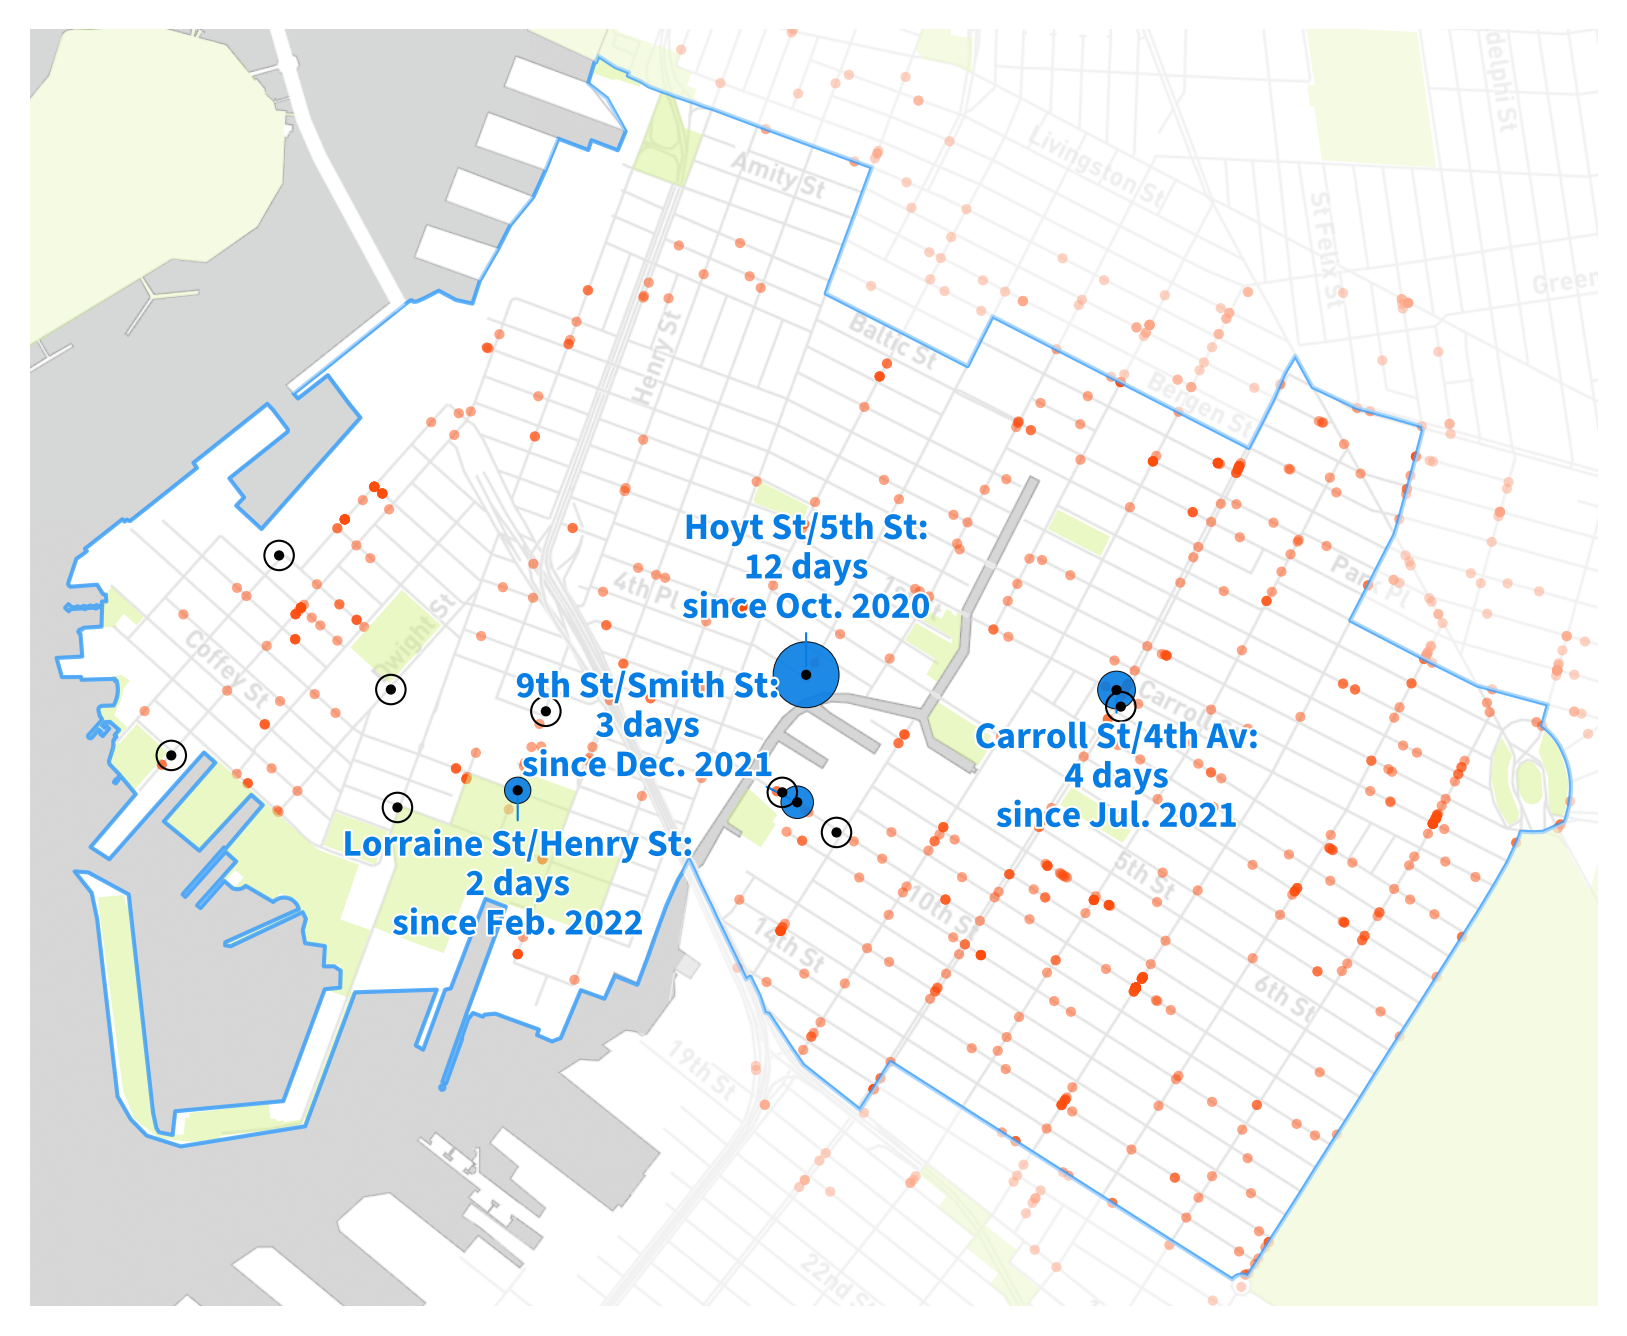

In [16]:
import matplotlib.patheffects as pe
from adjustText import adjust_text

local_cdta = cdta[cdta['CDTALabel'] == cd_name ].to_crs(3857)
other_cdta = cdta[cdta['CDTALabel'] != cd_name ].to_crs(3857)

fig,ax = plt.subplots( figsize=(5.225,4.5), dpi=300 )

# 1. ---------------  BOUNDARIES ------------------
local_cdta.plot( ax=ax , fc = 'none' , ec = light_blue, alpha = 0.8 , zorder = 10 )
other_cdta.plot( ax=ax , fc = 'white' , ec = 'none', alpha = 0.5, zorder = 10 )

# Define plot bounds by local cdta + padding
pad = 100
ax.set_xlim( local_cdta['geometry'].bounds.minx.values[0]-pad , local_cdta['geometry'].bounds.maxx.values[0]+pad )
ax.set_ylim( local_cdta['geometry'].bounds.miny.values[0]-pad , local_cdta['geometry'].bounds.maxy.values[0]+pad )

# Sensors with Flooding
with_flooding = flooded_days_map[ flooded_days_map['flooded_days'].notnull() ]

# 2. ------------- WITH FLOODING --------------
# BLUE CIRCLE
t = sns.scatterplot(
    x = with_flooding.geometry.x,
    y = with_flooding.geometry.y,
    ax = ax,
    facecolor = "#057de4",
    edgecolor = 'black',
    linewidth = 0.25,
    size = with_flooding[ 'flooded_days' ],
    sizes = ( 40 , 250 ),
    alpha = 0.9,
    zorder = 3,
)

# BLACK DOT
flooded_days_map.plot( ax=ax, markersize = 6 , fc = 'black' , ec = 'none' , alpha = 1 , zorder = 10 )
# 311 orange points
data_311.to_crs(3857).plot( ax=ax , fc = '#fe4c0c' , ec = 'none', alpha = 0.5 , zorder = 2 , markersize=6 )

# Annotations
texts = with_flooding.apply(
    lambda x: ax.annotate( 
        text = f"{x['sensor_display_name']}:\n{int(x['flooded_days']) } days\nsince {pd.to_datetime(x['time_NY']).strftime('%b. %Y')}", 
        xy = ( x.geometry.x , x.geometry.y ) , 
        ha = 'center' , va = 'bottom' , 
        xycoords = 'data' ,
        fontsize = 9, fontweight='bold' , color = '#057de4', zorder=100 ,
        path_effects=[pe.withStroke(linewidth=1, foreground="w")]),
    axis = 1
)

# 3. ------------- NO FLOODING --------------
no_flooding = flooded_days_map[ flooded_days_map['flooded_days'].isnull() ]
t2 = no_flooding.plot( ax=ax, markersize=50, fc='none', ec='black', lw=0.5 , zorder=10 )

circles = [ c for c in t.get_children() if isinstance(c, mpl.collections.PathCollection) ]
circles2 = [ c for c in t2.get_children() if isinstance(c, mpl.collections.PathCollection) ]

# Adjust Text so they are not intersecting
adjust_text(
    texts, 
    x = with_flooding.geometry.x, y = with_flooding.geometry.y,
    autoalign='y',
    force_text = (0.001,0.1), force_objects = (0.001,0.1),
    only_move={'text':'y','point':'y'} , add_objects= circles + circles2, 
    ha='center', precision=0.000000001,
    arrowprops=dict(arrowstyle="-", color="#057de4" , lw=0.5) )

all_parks = gpd.read_file( os.path.join( report_folder, 'Data', "NYC_Parks_Simplified_FIlled.geojson" ) , crs=4326 )
all_parks = all_parks.to_crs(3857)
all_parks.plot( ax=ax , fc = '#d4f28d' , ec = 'none', alpha = 0.5 , zorder = 2 )

mapbox_url = "https://api.mapbox.com/styles/v1/cankadir/clplqlyio001o01qmewg54ov3/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY2Fua2FkaXIiLCJhIjoiY2pteXplNnEzMHF3YTNrcGx0dGd4MmJrdiJ9.zbhQ39YIdfZufTljuTSl1w"
ctx.add_basemap( ax, source = mapbox_url, attribution="" )

ax.axis('off')
ax.legend([], frameon=False)

plt.tight_layout(pad=0)

map1_path = os.path.join( visual_folder , "map1.png" )
plt.savefig( map1_path , dpi = 150, bbox_inches='tight' ,transparent="True", pad_inches=0);

### MAP 2: Inset Map, of NYC

In [17]:
flooded_days_all = flood_data.groupby( ['deployment_id', pd.Grouper(key='time_NY', freq='1d')] ).agg({'clean_depth_in':'max' }).reset_index()
flooded_days_all = flooded_days_all[ flooded_days_all['clean_depth_in'] > 0.0 ]
flooded_days_all = flooded_days_all.groupby('deployment_id').size().reset_index().rename(columns={0:'flooded_days'})

flooded_days_all.head(3)

,deployment_id,flooded_days
0,asleep_apricot_bedbug,1
1,big_pink_elephant,3
2,blue_eyed_tiger,1


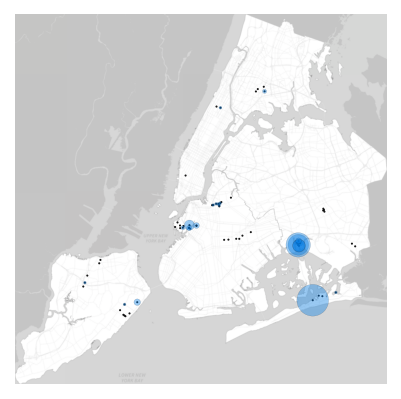

In [18]:
fig,ax = plt.subplots(figsize=(2.475,2.475), dpi=150)

projected_cdta = cdta.dissolve().to_crs(3857)
# projected_cdta.plot( ax=ax , fc = 'white' , ec = 'none', alpha = 1 )

sensor_locations = flood_data.groupby('deployment_id').agg({
        'lat':'first',
        'lon':'first'
    }).reset_index()

sensor_locations = gpd.GeoDataFrame( sensor_locations, geometry=gpd.points_from_xy(sensor_locations.lon, sensor_locations.lat), crs=4326 ).to_crs(3857) 
sensor_locations.plot( ax=ax , fc = 'black' , ec = 'none', alpha = 0.9 , markersize = 1 )

flood_locations = sensor_locations.join( flooded_days_all.set_index('deployment_id'), on='deployment_id' ).dropna( axis=0 )
flood_locations.plot( ax=ax , fc = "#057de4" , ec = 'black', lw=0.1 , alpha = 0.4 , markersize = flood_locations['flooded_days'] * 2 )

# Define plot bounds by local cdta + padding
pad = 10
ax.set_xlim( projected_cdta['geometry'].bounds.minx.values[0]-pad , projected_cdta['geometry'].bounds.maxx.values[0]+pad )
ax.set_ylim( projected_cdta['geometry'].bounds.miny.values[0]-pad , projected_cdta['geometry'].bounds.maxy.values[0]+pad )

mapbox_url = "https://api.mapbox.com/styles/v1/cankadir/clplqlyio001o01qmewg54ov3/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiY2Fua2FkaXIiLCJhIjoiY2pteXplNnEzMHF3YTNrcGx0dGd4MmJrdiJ9.zbhQ39YIdfZufTljuTSl1w"
ctx.add_basemap( ax, source= mapbox_url, attribution="" )
ax.axis('off')

plt.tight_layout(pad=0)
insetmap_path = os.path.join( visual_folder , "insetmap.png" )
plt.savefig( insetmap_path , dpi = 150, bbox_inches='tight' ,transparent="True", pad_inches=0)

### 311 Heatmap

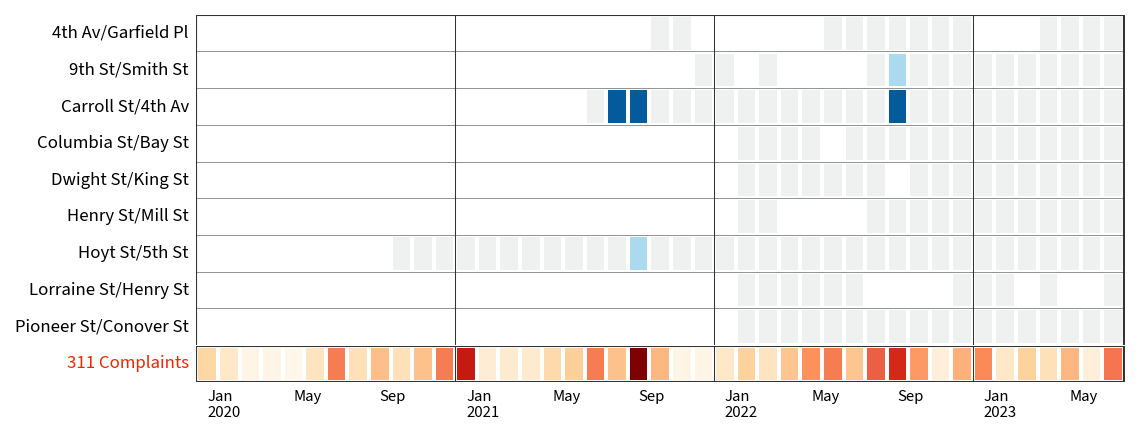

In [19]:
# remove UTC info from time_NY column
f = '1M'

time_min = local_data['time_NY'].max() - pd.Timedelta( weeks = 6*4 )
local_data['time_NY'] = local_data['time_NY'].dt.tz_localize(None)

filtered_data = local_data.copy()
sensors_over_time = local_data.groupby( ['sensor_display_name', pd.Grouper(key='time_NY', freq=f)] ).agg({'clean_depth_in':'max'}).reset_index()
sensors_over_time = sensors_over_time[ ~sensors_over_time['sensor_display_name'].str.contains('RET')]

pt = pd.pivot_table(
    sensors_over_time,
    index='sensor_display_name',
    columns='time_NY',
    values='clean_depth_in',
)

data_311['created_date'] = pd.to_datetime(data_311['created_date'])
filtered_311 = data_311[ data_311['created_date'] < local_data['time_NY'].max() ]

monthly_311 = filtered_311.groupby( pd.Grouper(key='created_date', freq=f) ).agg({'unique_key':'nunique'}).reset_index().rename(columns={'unique_key':'count'})
monthly_311['ind'] = '311 Complaints'
monthly_311 = monthly_311.pivot( index='ind', columns='created_date', values='count' )

# join and drop to equalize the ranges
pt = pd.concat( [pt,monthly_311] ).drop( index="311 Complaints" )

pt.index = [i.split(' - ')[1] if '-' in i else i for i in pt.index ]

# Segmented Color Map
def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

custom_ramp = make_Ramp( ['#EFF0F0',"#ABDAEF","#58B4ED", '#0586CE', '#045B9B'] ) 
values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

fig, axs = plt.subplots( nrows = 2 , figsize=(7.7,3), height_ratios=[pt.shape[0],1] , sharex=True , dpi=150 )

# ------------------ Flood VIZ ------------------
ax = axs[0]
sns.heatmap(
    pt,
    ax=ax,
    cmap= custom_ramp,
    cbar=False,
    lw=1,
    linecolor='w',
)

# [ ax.axvline(ticks-0.5, color='black', lw=0.5 ) for labels,ticks in zip(ax.get_xticklabels(),ax.get_xticks()) if pd.to_datetime(labels.get_text()).month == 1 ]

ax.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False )
ax.tick_params( axis='y', which='both', left=False , labelsize=9, pad=0.1 )
ax.set_ylabel('')
ax.set_xlabel('')

[ ax.axhline( i+0.495 , color='#333' , lw=0.25 ) for i in ax.get_yticks()]

# draw frame
ax.axhline( 0, color='#333', lw=1 )
ax.axvline( 0, color='#333', lw=1 )
ax.axvline( ax.get_xticks()[-1]+0.5 , color='#333', lw=1 )


# ----------------- 311 VIZ -----------------
ax = axs[1]
sns.heatmap(
    monthly_311,
    ax=ax,
    cmap= 'OrRd',
    cbar=False,
    lw=1,
    linecolor='w',
)

ax.tick_params( axis='y', which='both', left=False, rotation=0 , labelsize=9, pad=0.1 )
ax.tick_params( axis='x', which='both', bottom=False , pad=0.1 )

ax.set_ylabel('')
ax.set_xlabel('')

# draw frame
ax.axhline( 0, color='#333', lw=1 )
ax.axhline( 1, color='#333', lw=1 )
ax.axvline( 0, color='#333', lw=1 )
ax.axvline( ax.get_xticks()[-1]+0.5 , color='#333', lw=1 )

# x-ticks
ax.set_xticks( np.arange( 0.5 , ax.get_xticks()[-1] , 4 ) )
xticklabels = [ pd.to_datetime(x.get_text()).strftime('%b') if pd.to_datetime(x.get_text()).strftime('%b') != 'Jan' else f"{pd.to_datetime(x.get_text()).strftime('%b')}\n{pd.to_datetime(x.get_text()).strftime('%Y')}"  for x in ax.get_xticklabels() ]
ax.set_xticklabels( xticklabels , rotation=0 , ha='left', va='top' , fontsize=8 )
ax.set_yticklabels( ['311 Complaints'], color='#Ef2700' )

[ axs[1].axvline(ticks-0.5, color='#333', lw=0.5 ) for labels,ticks in zip(ax.get_xticklabels(),ax.get_xticks()) if "Jan" in labels.get_text() ]
[ axs[0].axvline(ticks-0.5, color='#333', lw=0.5 ) for labels,ticks in zip(ax.get_xticklabels(),ax.get_xticks()) if "Jan" in labels.get_text() ]

ax.set_xlim( ax.get_xlim()[0] , ax.get_xlim()[1]+0.05 )
plt.tight_layout( h_pad=0.025 )

heatmap_path = os.path.join( visual_folder , "heatmap_311.png" )
plt.savefig( heatmap_path , bbox_inches='tight' ,transparent="True", pad_inches=0)

## FLOOD DAYS

#### Highlighted events
Using NYU's metadata to get hightlighted events and sensor

In [20]:
# "C:\Users\cansu\Dropbox\FloodNet_Report_Automation\DATA\Neighborhood Flood Reports Sensor List Metadata.xlsx"
sensor_metadata = r"C:\Users\cansu\Dropbox\FloodNet_Report_Automation\DATA\Neighborhood Flood Reports Sensor List Metadata.xlsx"
sensor_metadata = pd.read_excel( sensor_metadata , sheet_name='Sensor list + metadata' )

highlighted_sensor = sensor_metadata[ ( sensor_metadata['Highlighted Event Start - Nov 2023'].notnull() ) & ( sensor_metadata['neighborhood_label'] == cd_name ) ]
highlighted_sensor.head()

,sensor_display_name,sensor_address_borough,neighborhood_label,date_deployed,deployment_id,Highlighted Event Start - Nov 2023,Highlighted Event End - Nov 2023,Event type (Coastal/Pluvial)
5,BK - Carroll St/4th Av,Brooklyn,Red Hook-Park Slope-Carroll Gardens,2021-07-15,weekly_poetic_guinea,2021-09-02 01:27:30+00:00,2021-09-02 03:11:30+00:00,Pluvial


2021-09-01 21:27:30 2021-09-01 23:11:30


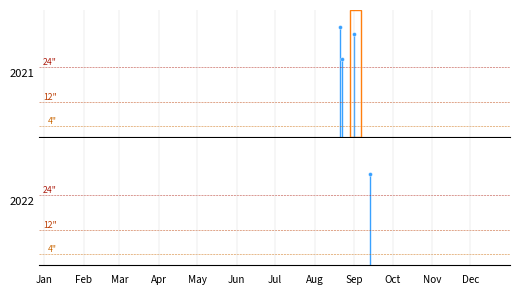

In [25]:
from matplotlib.ticker import MultipleLocator

filtered_data = local_data.dropna( subset=['sensor_display_name'] ,axis=0 )

# Single sensor
single_sensor = filtered_data[ filtered_data['deployment_id'] == highlighted_sensor['deployment_id'].values[0] ].copy()

# All neighborhood sensors
# single_sensor = filtered_data.copy()

f = '1D'
single_sensor_1h = single_sensor.groupby(pd.Grouper(key='time_NY', freq=f)).agg({'clean_depth_in':'max'}).reset_index()

single_sensor_1h['date'] = single_sensor_1h['time_NY'].dt.date
single_sensor_1h['hour'] = single_sensor_1h['time_NY'].dt.hour
single_sensor_1h['year'] = single_sensor_1h['time_NY'].dt.year

single_sensor_1h['flat_date'] = single_sensor_1h['time_NY'].dt.strftime('1900-%m-%d %H:%M:%S')
single_sensor_1h['flat_date'] = pd.to_datetime( single_sensor_1h['flat_date'] )
single_sensor_1h['flat_date_end'] = single_sensor_1h['flat_date'] + pd.Timedelta( f )

grid_colors = ['#ca6702','#bb3e03','#ae2012']
values = ['Minor Flood', 'Moderate Flood', 'Major Flood']

fig,axs = plt.subplots( nrows = single_sensor_1h[single_sensor_1h['clean_depth_in'] > 0]['year'].nunique() , sharex=True, sharey=True, figsize = (5,2.75) )

for i,year in enumerate( single_sensor_1h[single_sensor_1h['clean_depth_in'] > 0]['year'].unique() ):
    ax = axs[i]
    single_sensor_1h_year = single_sensor_1h[ single_sensor_1h['year'] == year ]

    ax.vlines( ymax=single_sensor_1h_year['clean_depth_in'], ymin=0, x=single_sensor_1h_year['flat_date'] , alpha=1 , lw=1, color='#39a1ff' )

    single_sensor_1h_year_above = single_sensor_1h_year[ single_sensor_1h_year['clean_depth_in'] > 0 ]
    ax.scatter( y=single_sensor_1h_year_above['clean_depth_in'], x=single_sensor_1h_year_above['flat_date'], s=8 , marker='o', lw=0.25 ,fc='#39a1ff' ,ec='w', zorder=5 )

    ax.set_ylim( 0, single_sensor_1h['clean_depth_in'].max() + 6 )
    ax.set_ylabel( year, rotation=0 , labelpad=3, fontsize = 9 , ha='right', va='center' )
    sns.despine( ax=ax, left=True )

    # format y-axis as %b %d
    ax.xaxis.set_major_formatter( mdates.DateFormatter('%b') )
    # every month
    ax.xaxis.set_major_locator( mdates.MonthLocator() )

    ax.set_xlim( pd.to_datetime('28-12-1899 00:00:00',dayfirst=True) , pd.to_datetime('31-12-1900 23:59:59',dayfirst=True) )
    ax.tick_params(axis='y', which='both', left=False, labelleft=False )
    ax.tick_params( axis='x' , labelsize=8 , bottom=False )

    [ ax.axhline(t, ls='--', lw=0.4, alpha=0.8, color=grid_colors[n]) for n,t in enumerate([4,12,24]) ]
    [ ax.annotate(f'{t}"', xy=( pd.to_datetime('01-01-1900')+pd.Timedelta(days=10),t) ,color=grid_colors[n], va='bottom', ha='right', fontsize=7 ) for n,t in enumerate([4,12,24]) ]
    
    [ ax.axvline( pd.to_datetime( f'{i}-01-1900' ), color="#cecece", lw=0.25, alpha=1 ) for i in range(1,13)]


    event_startdate = highlighted_sensor['Highlighted Event Start - Nov 2023'].values[0]
    event_startdate = pd.to_datetime( event_startdate )
    event_startdate = event_startdate.tz_convert('America/New_York').tz_localize(None)
    
    event_enddate = highlighted_sensor['Highlighted Event End - Nov 2023'].values[0]
    event_enddate = pd.to_datetime( event_enddate )
    event_enddate = event_enddate.tz_convert('America/New_York').tz_localize(None)

    if year == event_startdate.year :
        
        print( event_startdate , event_enddate )
        event_converted_startdate = pd.to_datetime( f'1900-{event_startdate.month}-{event_startdate.day} {event_startdate.hour}:00:00' )
        event_converted_enddate = pd.to_datetime( f'1900-{event_enddate.month}-{event_enddate.day} {event_enddate.hour}:00:00' )
        
        event_midpoint = event_converted_startdate + ( event_converted_enddate - event_converted_startdate ) / 2

        event_converted_startdate = event_midpoint - pd.Timedelta( days = 4.5 )
        event_converted_enddate = event_midpoint + pd.Timedelta( days = 4.5 )

        ax.axvspan( event_converted_startdate , event_converted_enddate , ec='#ff7f0e', fc='none', alpha=1 , zorder=150 )
    

plt.tight_layout( pad=0, h_pad=0.05 )
fig.savefig( os.path.join( visual_folder , "flood_timeline.png" ) ,bbox_inches='tight', transparent="True" , pad_inches=0 , dpi=150 )

#### Pop-Up Chart

In [26]:
event_startdate = highlighted_sensor['Highlighted Event Start - Nov 2023'].values[0]
event_startdate = pd.to_datetime( event_startdate )

event_enddate = highlighted_sensor['Highlighted Event End - Nov 2023'].values[0]
event_enddate = pd.to_datetime( event_enddate )

event_startdate , event_enddate

(Timestamp('2021-09-02 01:27:30+0000', tz='UTC'),
 Timestamp('2021-09-02 03:11:30+0000', tz='UTC'))

In [27]:
flood_type = highlighted_sensor['Event type (Coastal/Pluvial)'].values[0]
flood_type

'Pluvial'

In [74]:
import requests

if flood_type == 'Coastal':
    url = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20221220&end_date=20221230&station=8518750&product=water_level&datum=MLLW&time_zone=gmt&units=english&application=DataAPI_Sample&format=json'
    r = requests.get(url)
    data = r.json()['data']
    tidal = pd.DataFrame( data )
    tidal['t'] = pd.to_datetime(tidal['t']).dt.tz_localize('utc').dt.tz_convert('US/Eastern').dt.tz_localize(None)
    tidal = tidal.set_index('t').drop(['q','f'],axis=1).astype(float)
    background_data = tidal.copy()

if flood_type == 'Pluvial':
    event_startdate_ext = event_startdate - pd.Timedelta( days = 1 )
    event_enddate_ext = event_enddate + pd.Timedelta( days = 1 )

    url = f'https://api.weather.com/v1/location/KLGA:9:US/observations/historical.json?apiKey=e1f10a1e78da46f5b10a1e78da96f525&units=e&startDate={event_startdate_ext.year}{str(event_startdate_ext.month).zfill(2)}{str( event_startdate_ext.day ).zfill(2)}&endDate={event_enddate_ext.year}{str(event_enddate_ext.month).zfill(2)}{str( event_enddate_ext.day ).zfill(2)}'
    rain = requests.get(url).json()

    rain = pd.DataFrame( rain['observations'] )
    rain['time'] = pd.to_datetime(rain['valid_time_gmt'], unit='s')
    rain['time_NY'] = rain['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None)

    background_data = rain.copy()

background_data.head(3)

,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,wx_phrase,pressure_tend,pressure_desc,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,gust,wspd,max_temp,min_temp,precip_total,precip_hrly,snow_hrly,uv_desc,feels_like,uv_index,qualifier,qualifier_svrty,blunt_phrase,terse_phrase,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction,time,time_NY
0,KLGA,observation,1630479060,KLGA,New York/LaGuardia,1630471860,N,81,26,2600,Cloudy,NaN,None,63,82,54,29.77,10.0,81,270.0,W,NaN,3,87.0,76.0,NaN,0.0,None,Low,82,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,2021-09-01 04:51:00,2021-09-01 00:51:00
1,KLGA,observation,1630482660,KLGA,New York/LaGuardia,1630475460,N,79,26,2600,Cloudy,2.0,Falling Rapidly,63,81,58,29.76,10.0,79,NaN,CALM,NaN,0,NaN,NaN,NaN,0.0,None,Low,81,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,2021-09-01 05:51:00,2021-09-01 01:51:00
2,KLGA,observation,1630486260,KLGA,New York/LaGuardia,1630479060,N,80,26,2600,Cloudy,NaN,None,63,81,56,29.75,10.0,80,NaN,CALM,NaN,0,NaN,NaN,NaN,0.0,None,Low,81,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,2021-09-01 06:51:00,2021-09-01 02:51:00


,time_NY,precip_hrly
0,2021-09-01 20:40:00,0.66
1,2021-09-01 21:00:00,0.09
2,2021-09-01 21:20:00,0.80
3,2021-09-01 21:40:00,2.21
4,2021-09-01 22:00:00,NaN
5,2021-09-01 22:20:00,NaN
6,2021-09-01 22:40:00,2.18
7,2021-09-01 23:00:00,0.14


C:\Users\cansu\AppData\Local\Temp\ipykernel_3336\2590832609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels( [f'{t}"\nHrly\nPrec.' if t==ax2.get_yticks()[-1] else f'{t}"' for t in ax2.get_yticks()] )
C:\Users\cansu\AppData\Local\Temp\ipykernel_3336\2590832609.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels( [f'{i:.0f}"' for i in ax.get_yticks()] , color='#2093f2' )


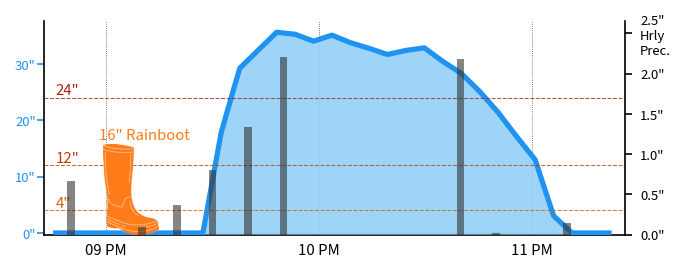

In [138]:
# single sensor, hightlighted event
single_sensor = flood_data[ flood_data['deployment_id'] == highlighted_sensor['deployment_id'].values[0] ].copy()

# Add some padding to the plot
event_start_time_NY =  event_startdate.tz_convert('America/New_York').tz_localize(None) - pd.Timedelta( hours = 0.75 )
event_end_time_NY =  event_enddate.tz_convert('America/New_York').tz_localize(None) + pd.Timedelta( hours = 0.25 )

# Filter data
single_sensor['time_NY'] = single_sensor['time_NY'].dt.tz_localize(None)
filtered_data = single_sensor[ (single_sensor['time_NY'] >= event_start_time_NY ) & (single_sensor['time_NY'] <= event_end_time_NY ) ]

fig,ax = plt.subplots( figsize=(5,1.85) , dpi=150 )
sns.despine(left=False, ax=ax )

# PLOT
ax.plot( filtered_data['time_NY'], filtered_data['clean_depth_in'], lw=2.5, color='#2093f2' , zorder=10 , label='Flooding' )
ax.fill_between( filtered_data['time_NY'], filtered_data['clean_depth_in'], color="#92d0f7", alpha=0.9 , zorder=9 )

# Make sure the y-axis is always higher than 18"
ax.set_xlim( event_start_time_NY , event_end_time_NY )
if filtered_data['clean_depth_in'].max() + 2 > 18:
    ax.set_ylim( -0.3 , filtered_data['clean_depth_in'].max() + 2 )
else:
    ax.set_ylim( -0.3 , 18 )

# RAIN FALL or TIDE

if flood_type == 'Pluvial':

    ax2 = ax.twinx()
    # filter backgorund data
    background_data_filtered = background_data[ (background_data['time_NY'] >= event_start_time_NY ) & (background_data['time_NY'] <= event_end_time_NY ) ]
    background_data_filtered = background_data_filtered.groupby( pd.Grouper(key='time_NY', freq='10min') ).agg({'precip_hrly':'max'}).reset_index()
    ax2.bar( background_data_filtered['time_NY'], background_data_filtered['precip_hrly'] , width=0.0015 , fc='#333', ec='none', alpha=0.6 , zorder=5, label='Hourly Precipitaion' )
    ax2.set_xlim( event_start_time_NY , event_end_time_NY )
    
    for i in ['left','top','bottom']: ax2.spines[i].set_visible(False)
    ax2.yaxis.tick_right()
    ax2.tick_params(axis='y',which='both',left=False, labelleft=False , labelsize=7 )
    
    # # add " to highset y-tick
    ax2.set_yticklabels( [f'{t}"\nHrly\nPrec.' if t==ax2.get_yticks()[-1] else f'{t}"' for t in ax2.get_yticks()] )
    ax2.set_ylim( 0 , background_data['precip_hrly'].max() * 1.2 )
else:
    print('Coastal')
    # ax.plot( background_data['time_NY'], background_data['cumulative_precip'] , lw=0.35 , ls='--', color='#333', alpha=0.75 )
    # ax.annotate( 'Cumulative Rainfall' , xy=(  event_end_time_NY , background_data[ background_data['time_NY'].round('1h') == event_end_time_NY.round('1h') ]['cumulative_precip'].values[0] ) , ha='right', va='bottom', fontsize=7.5 , color='#333', alpha=0.75 )

# Flood Measures
grid_colors = ['#ca6702','#bb3e03','#ae2012']
[ ax.axhline(t, ls='--', lw=0.5, alpha=0.8, color=grid_colors[n] , zorder=11) for n,t in enumerate([4,12,24])  ]
[ ax.annotate(f'{t}"', xy=( filtered_data['time_NY'].min() , t) ,color=grid_colors[n], va='bottom', ha='left', fontsize=8 , zorder=11 ) for n,t in enumerate([4,12,24]) ]

# Ticks formatting
ax.grid(axis='x', color='#333', lw=0.35, ls=":", zorder = 14 )
ax.tick_params(axis='y', which='both', left=True, labelleft=True , labelsize=7 , pad=0.5, color='#2093f2' )

ax.set_yticklabels( [f'{i:.0f}"' for i in ax.get_yticks()] , color='#2093f2' )

ax.xaxis.set_major_locator( mdates.HourLocator(interval=1) )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))
ax.tick_params( axis='x', labelsize=8 , pad=0.5, bottom=False )


# RAINBOOT
# A new axis is formed -> height of the axis is plot height / flood height, to match 16
rainboot = r"C:\Users\cansu\Dropbox\FloodNet_Report_Automation\DATA\rainboot_16inch_orange-01.png"
rainboot = plt.imread( rainboot , format='png' )
height_ratio = 16 / (ax.get_ylim()[1] - ax.get_ylim()[0])
axin = ax.inset_axes( [0.05 , 0 , 0.2 , height_ratio ]  )    # create new inset axes in data coordinates
axin.imshow( rainboot , zorder=100 )
axin.axis('off')

# order plots
ax.set_zorder(2)
ax.set_facecolor("none")
ax2.set_zorder(3)
ax2.set_facecolor("none")
axin.set_zorder(100)
axin.set_facecolor("none")

ax.annotate( '16" Rainboot' , xy=( 0.25 , height_ratio + 0.01 ), xycoords='axes fraction' , ha='right', va='bottom', fontsize=8 , color='#FF7C1A' )

fig.savefig( os.path.join( visual_folder , "flood_timeline_zoom.png" ) ,bbox_inches='tight', transparent="True" , pad_inches=0 , dpi=150 )

### Get Photos From MyCoast

In [139]:
# check if myCoast_photos folder exists in the visual folder
if not os.path.exists( os.path.join( visual_folder , 'myCoast_photos' ) ):
    os.makedirs( os.path.join( visual_folder , 'myCoast_photos' ) )
photos_folder = os.path.join( visual_folder , 'myCoast_photos' )

url = 'https://mycoast.org/wp-admin/admin-ajax.php?action=mapp_query& \
    query[category_name]=highwater&query[tag__and][]=121& \
    url[href]=https://mycoast.org/ny/flood-watch&url[search]='

headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/116.0'}

response = requests.get(url, headers=headers)
data = response.json()
data = data['data']

myCoast_data = pd.DataFrame( data['pois'] )

print( myCoast_data.shape[0] , 'data points found' )
myCoast_data.head()

1410 data points found


,address,body,data,email,iconid,images,kml,name,oid,otype,point,poly,props,title,type,url,viewport
0,"40.5763172463, -73.8582246418",,None,None,highwater.svg,None,None,None,142091,post,"{'lat': '40.5763172463', 'lng': '-73.8582246418'}",None,"{'geo_locality': '', 'geo_administrative_area_...",40.5763172463 -73.8582246418,None,https://mycoast.org/reports/142091,None
1,"40.65334759246563, -73.83004722028804",,None,None,highwater.svg,None,None,None,134073,post,"{'lat': '40.65334759246563', 'lng': '-73.83004...",None,"{'geo_locality': '', 'geo_administrative_area_...",40.65334759246563 -73.83004722028804,None,https://mycoast.org/reports/134073,None
2,"40.8059335163, -72.6390809542",,None,None,highwater.svg,None,None,None,129855,post,"{'lat': '40.8059335163', 'lng': '-72.6390809542'}",None,"{'geo_locality': 'Westhampton Beach', 'geo_adm...",40.8059335163 -72.6390809542,None,https://mycoast.org/reports/129855,None
3,"40.657703438427546, -73.83808084475532",,None,None,highwater.svg,None,None,None,128901,post,"{'lat': '40.657703438427546', 'lng': '-73.8380...",None,"{'geo_locality': '', 'geo_administrative_area_...",40.657703438427546 -73.83808084475532,None,https://mycoast.org/reports/128901,None
4,"40.9187036, -73.1770703",,None,None,highwater.svg,None,None,None,128581,post,"{'lat': '40.9187036', 'lng': '-73.1770703'}",None,"{'geo_locality': 'Nissequogue', 'geo_administr...",40.9187036 -73.1770703,None,https://mycoast.org/reports/128581,None


In [142]:
myCoast_data['photo_date'] = myCoast_data['props'].apply( lambda x: x['photo_date'] )
myCoast_data['photo_time'] = myCoast_data['props'].apply( lambda x: x['photo_time'] )
myCoast_data['pics'] = myCoast_data['props'].apply( lambda x: x['ourPics'] )

myCoast_data['lat'] = myCoast_data['point'].apply( lambda x: x['lat'] )
myCoast_data['lon'] = myCoast_data['point'].apply( lambda x: x['lng'] )
myCoast_data['pic_urls'] = myCoast_data['pics'].apply( lambda x: [i.split('/></a>')[0].replace("'","") for i in x.split('src=') if 'https' in i] )
myCoast_data['pic_count'] = myCoast_data['pic_urls'].apply( lambda x: len(x) )
myCoast_data[[ 'url','images','photo_date','photo_time','pics','lat','lon','pic_urls', 'pic_count' ]]

,url,images,photo_date,photo_time,pics,lat,lon,pic_urls,pic_count
0,https://mycoast.org/reports/142091,None,2023-11-27,8:14 am,<div class='search-result-single-image-wrapper...,40.5763172463,-73.8582246418,[https://report-images.nyc3.digitaloceanspaces...,3
1,https://mycoast.org/reports/134073,None,2023-10-30,10:00 am,<div class='search-result-single-image-wrapper...,40.65334759246563,-73.83004722028804,[https://report-images.nyc3.digitaloceanspaces...,1
2,https://mycoast.org/reports/129855,None,2023-10-16,10:17 am,<div class='search-result-single-image-wrapper...,40.8059335163,-72.6390809542,[https://report-images.nyc3.digitaloceanspaces...,1
3,https://mycoast.org/reports/128901,None,2023-10-01,10:20 am,<div class='search-result-single-image-wrapper...,40.657703438427546,-73.83808084475532,[https://report-images.nyc3.digitaloceanspaces...,1
4,https://mycoast.org/reports/128581,None,2023-09-30,12:57 pm,<div class='search-result-single-image-wrapper...,40.9187036,-73.1770703,[https://report-images.nyc3.digitaloceanspaces...,1
...,...,...,...,...,...,...,...,...,...
1405,https://mycoast.org/reports/134507,None,2018-09-10,09:50 am,<div class='search-result-single-image-wrapper...,40.6534008,-73.8302549,[https://report-images.nyc3.digitaloceanspaces...,2
1406,https://mycoast.org/reports/136642,None,2016-02-09,05:00 pm,<div class='search-result-single-image-wrapper...,40.595873097,-73.771498369,[https://report-images.nyc3.digitaloceanspaces...,1
1407,https://mycoast.org/reports/102633,None,2016-02-09,03:43 pm,<div class='search-result-single-image-wrapper...,40.65720146993478,-73.84323120117188,[https://report-images.nyc3.digitaloceanspaces...,1
1408,https://mycoast.org/reports/20384,None,2015-09-30,10:51 am,<div class='search-result-single-image-wrapper...,40.7520353,-74.00785960000002,[https://report-images.nyc3.digitaloceanspaces...,1


In [159]:
myCoast_geo = gpd.GeoDataFrame( myCoast_data, geometry=gpd.points_from_xy(myCoast_data.lon, myCoast_data.lat), crs=4326 )

dist = 0.5
myCoast_photos_count = 0
while myCoast_photos_count < 3 :
    
    dist = dist + 0.1
    local_cdta['buffer_geometry'] = local_cdta['geometry'].to_crs(2263).buffer( 5280*dist ).to_crs(4326)
    buffer_cdta = local_cdta.set_geometry( 'buffer_geometry' )

    myCoast_cdta = myCoast_geo.sjoin( buffer_cdta )
    myCoast_photos_count = myCoast_cdta['pic_count'].sum()
    # print( dist , myCoast_photos_count , 'photos found' )

myCoast_cdta_wpics = myCoast_cdta[ myCoast_cdta['pic_count'] > 0 ].drop(['title','type','viewport','index_right','geometry_right'],axis=1).copy()
myCoast_cdta_wpics

,address,body,data,email,iconid,images,kml,name,oid,otype,point,poly,props,url,photo_date,photo_time,pics,lat,lon,pic_urls,pic_count,geometry_left,CDTAName,CDTALabel
36,"40.6493612, -74.0095916",,None,None,highwater.svg,None,None,None,115938,post,"{'lat': '40.6493612', 'lng': '-74.0095916'}",None,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/115938,2023-05-01,08:59 am,<div class='search-result-single-image-wrapper...,40.6493612,-74.0095916,[https://report-images.nyc3.digitaloceanspaces...,1,POINT (-74.00959 40.64936),BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens
1409,"40.6759445259, -74.0086725961",,None,None,highwater.svg,None,None,None,113708,post,"{'lat': '40.6759445259', 'lng': '-74.0086725961'}",None,"{'geo_locality': '', 'geo_administrative_area_...",https://mycoast.org/reports/113708,2012-10-22,7:30 pm,<div class='search-result-single-image-wrapper...,40.6759445259,-74.0086725961,[https://report-images.nyc3.digitaloceanspaces...,2,POINT (-74.00867 40.67594),BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Red Hook-Park Slope-Carroll Gardens


In [177]:
import lxml
import lxml.html

def extract_images( url ):
    response = requests.get(url, headers=headers)
    tree = lxml.html.fromstring(response.content)
    img = tree.xpath('//img')

    sources = []
    for i in img:
        source = i.attrib['src'] 
        if ("logo" not in source) and ("footer" not in source) :
            sources.append(source)
    return sources

def extract_comments( url):
    # get text or h content in div with class "post_author_comment"
    response = requests.get(url, headers=headers)
    tree = lxml.html.fromstring(response.content)
    comments = tree.xpath('//div[@class="post-author-comment"]//h6')
    comments = comments[0].text_content().replace('"','')
    return comments

myCoast_info = []
for i,r in myCoast_cdta_wpics.iterrows():
    url = r['url']
    picture_links = extract_images( url ) 
    comments = extract_comments( url ) 
    myCoast_info.append( [url,comments, picture_links] )
    
myCoast_info = pd.DataFrame( myCoast_info , columns=['url','comments','picture_links'] )
myCoast_info['picture_count'] = myCoast_info['picture_links'].apply( lambda x: len(x) )

myCoast_info

,url,comments,picture_links,picture_count
0,https://mycoast.org/reports/115938,It's not even raining today. The rain water wa...,[https://i0.wp.com/report-images.nyc3.digitalo...,1
1,https://mycoast.org/reports/113708,I’m not sure of the date or time. I do know th...,[https://i0.wp.com/report-images.nyc3.digitalo...,2


https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/05/01162226/subway-flood-scaled.jpg?h=800
https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/04/10092856/15398d64610490cc2682469ee5583f7c0c0fa0f1.jpg?h=550
https://i0.wp.com/report-images.nyc3.digitaloceanspaces.com/2023/04/10092859/343c358aaa171e60d970e6a48cbd63439303361f.jpg?h=550
[600.0, 369.45454545454544, 369.45454545454544]
[600.0, 738.9090909090909]


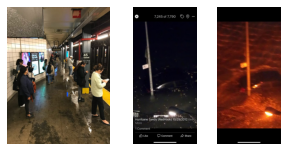

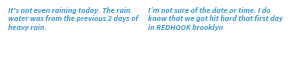

In [269]:
# plot images using matplotlib using links
from imageio.v2 import imread

imgs = []
sizes_widths = []
sizes_heights = []
for i,r in myCoast_info.iterrows():

    for link in r['picture_links']:
        print( link )
        a = imread( link )
        imgs.append( a )

        sizes_widths.append( (a.shape[1]) )
        sizes_heights.append( (a.shape[0]) )

max_height = max( sizes_heights )
test_widths = [ ((max_height/h) * w) for w,h in zip(sizes_widths,sizes_heights) ]

fig1,axs = plt.subplots( figsize=(5,2.475) , ncols = myCoast_info['picture_count'].sum() , width_ratios=test_widths , dpi=72 )
for count,img in enumerate(imgs):
    ax = axs[count]
    ax.imshow(img)
    ax.axis('off')

# sum test widths based on picture count
sum_widths = [ sum(test_widths[i:i+count]) for i,count in enumerate(myCoast_info['picture_count'].values) ]
print( test_widths )
print( sum_widths )
fig1.savefig( os.path.join( visual_folder , "myCoast_images.png" ) ,bbox_inches='tight', transparent="True" , pad_inches=0  )

fig,axs = plt.subplots( figsize=(5,1) , ncols = myCoast_info.shape[0] , width_ratios=sum_widths , dpi=72 )

for count, comment in enumerate(myCoast_info['comments'].values):
    ax = axs[count]
    ax.axis('off')

    txt = ax.text( 0.01 , 0.999 , comment , ha='left', va='top', fontsize=8 , color='#007acc', alpha=0.75 , transform=ax.transAxes , fontstyle='italic', fontweight='bold' , wrap=True)
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height

    txt._get_wrap_line_width = lambda : (width * 72)

fig.savefig( os.path.join( visual_folder , "myCoast_comments.png" ) ,transparent="True" , pad_inches=0 )
